Learn iterator for multiphase elastic problems using PAC-FEANet - predict the elastic response of Ti64

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ElasticityDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Test SAC-FEANet for elastic problems

In [3]:
train = False
nb_layers = 3
model_name = 'elasticity_type1_1phase_33x33_layer'+str(nb_layers)
training_set = ElasticityDataSet('data/Ti64/Ti64_256x256.h5', device)
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 5
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, fbody_train, usol_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

In [4]:
n_test = 2**8
test_set = ElasticityDataSet('data/Ti64/Ti64_256x256.h5', device)

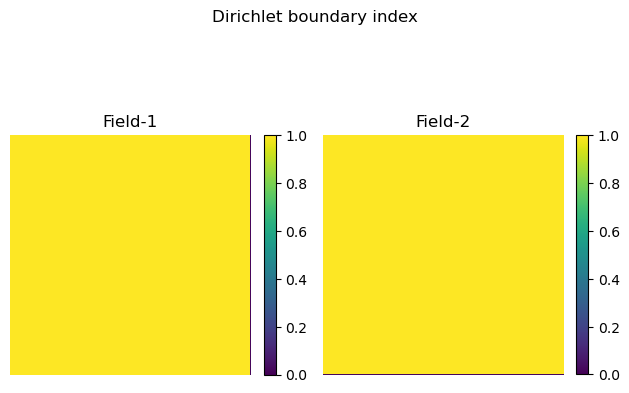

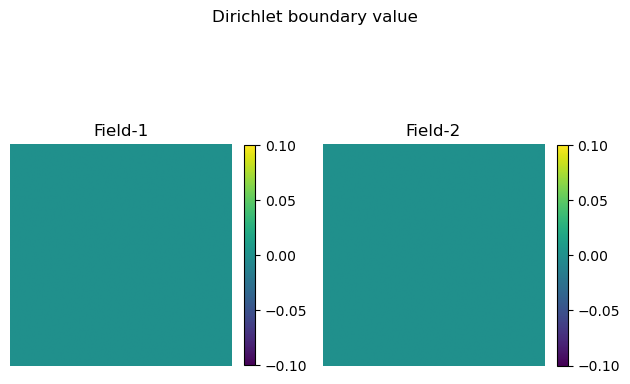

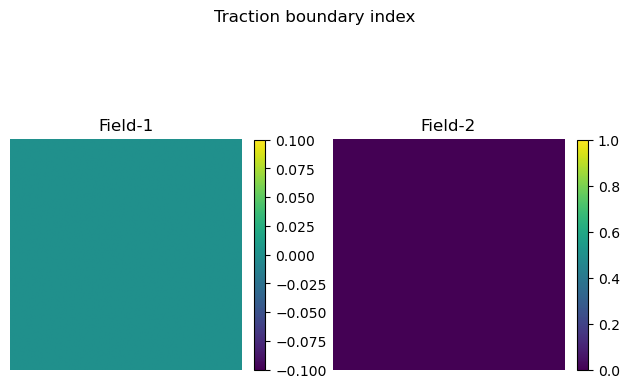

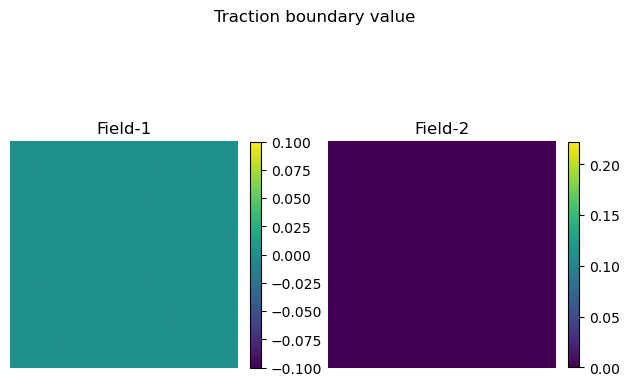

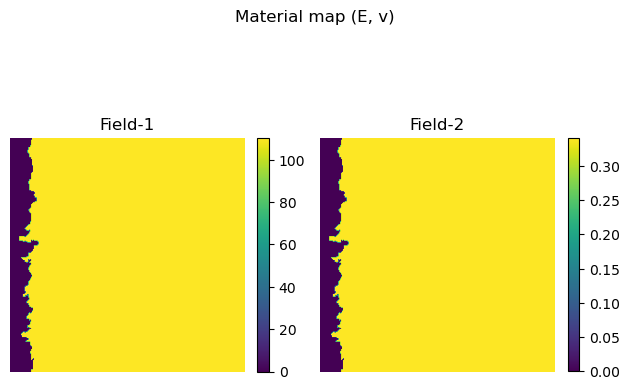

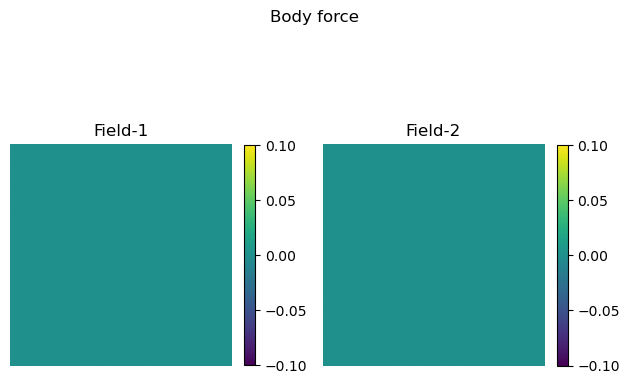

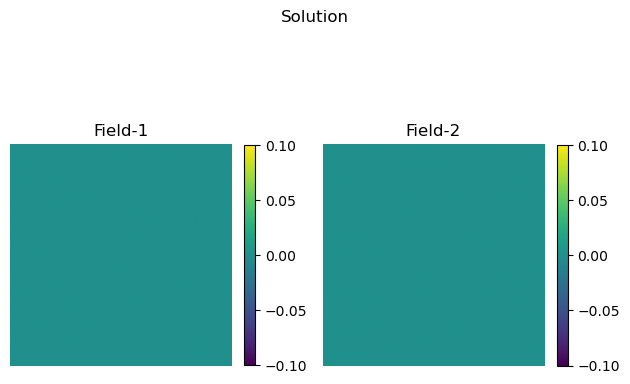

In [7]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(fbody_train[k], ftitle='Body force')
plot.plot_elasticfield(usol_train[k], ftitle='Solution')

In [8]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, dev):
        self.size = size # actual size of the plate
        self.mode = mode
        self.device = dev
        self.n_elem = n_elem
        self.h = size/n_elem
        self.v = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.f = torch.zeros((1, 1, n_elem+1, n_elem+1), requires_grad=False).double()
        self.net = self.InstantiateNetwork()
        self.jac = JacobiBlock(self.net, self.h, self.device, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.device, self.mode).double()
        model.requires_grad_(False)
        return model.to(self.device)

In [9]:
pixel = 0.0061e-3 # m
domain_size = 256*pixel # m
n_elem = 2**8
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic', dev=device_predict)

In [10]:
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(usol_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(fbody_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(traction_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


0 0.0
Solution converges after 0 Jacobi iterations 


/tmp/ipykernel_3446957/1481154702.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


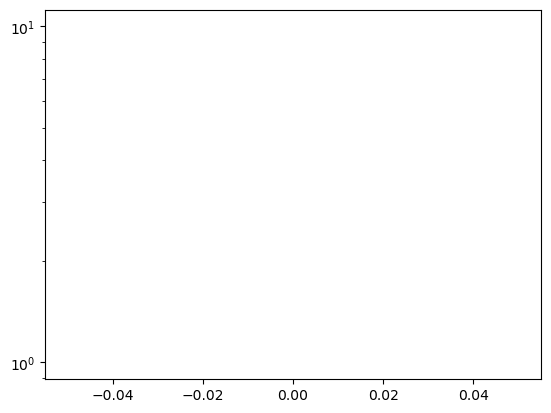

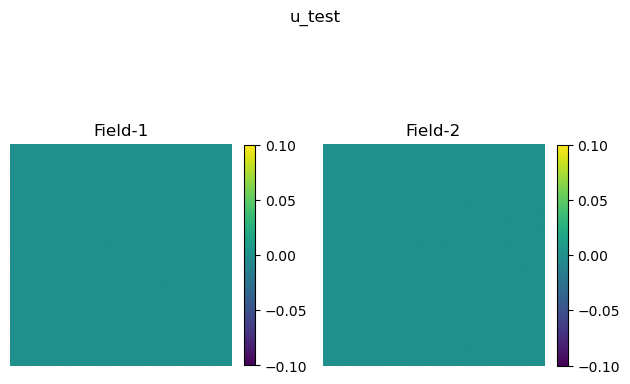

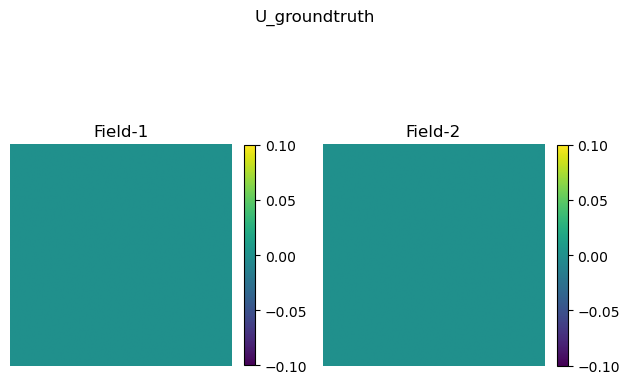

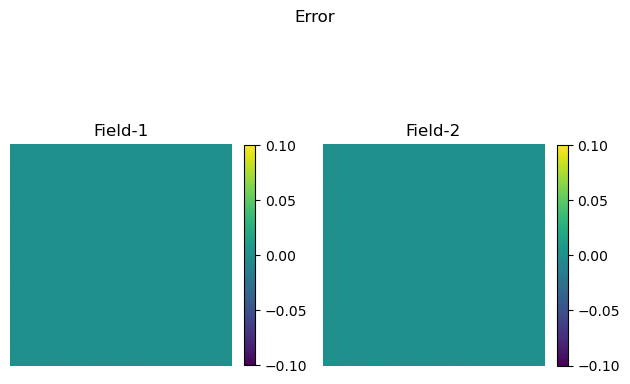

In [11]:
EPS = 1e-6
n_jac = 0
u_test = torch.zeros(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
u_test = grid.jac.reset_boundary(u_test, d_test, d_idx_test)
residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
res = torch.norm(residual).item() 
res_arr = [res]

print(n_jac, res)
while (abs(res) > EPS ):
    u_test = grid.jac.jacobi_convolution(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test)
    residual = d_idx_test*grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() 
    res_arr.append(res)
    n_jac += 1
    print(n_jac, res)
''''''

print("Solution converges after", n_jac, "Jacobi iterations ")

plt.plot(res_arr)
plt.yscale('log')
plt.show()

plot.plot_elasticfield(u_test[0], "u_test")
plot.plot_elasticfield(solution_test[0], "U_groundtruth")
plot.plot_elasticfield(u_test[0]-solution_test[0], 'Error')

In [10]:
class PsiNet(nn.Module):
    def __init__(self, nb_layers=3, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        '''
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 1, kernel_size=5, padding=2),
            nn.Conv2d(1, self.ku, kernel_size=1, padding=0),
            nn.BatchNorm2d(num_features=self.ku),
            nn.Unfold(kernel_size=3, padding=1),
            nn.Sigmoid()
            )
        '''

        self.smoother = nn.ModuleList([nn.Conv2d(self.ku, self.ku, 3, padding=1, bias=False)
                                         for _ in range(nb_layers)])

    def forward(self, m, x, dirich_idx):
        '''
        m: material field
        x: error between Jacobi solution and initial guess '''
        #bs0, ku0, h0, w0 = x.size()
        #new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention = self.attention_map(m).view(bs0, ku0, -1, h0, w0) # shape (bs, ku, 9, h, w)
        #attention_x = new_x * attention # shape (bs, ku, 9, h, w)
        #attention_x = attention_x.sum(dim=2) # shape (bs, ku, h, w)
        return reduce(lambda acc, el: el(acc) * dirich_idx, self.smoother, x) # shape (bs, ku, h, w)

In [11]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 dev,
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 nb_layers=3,
                 batch_size=1,
                 max_epochs=1000,
                 mode='thermal',
                 model_dir=model_dir):
        super(PsiIterator, self).__init__()
        self.size = size
        self.device = dev
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss()
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode=mode, dev=self.device)
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(nb_layers=nb_layers, mode=self.mode).to(self.device).double()
        else:
            self.psi_net = psi_net.to(self.device).double()

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir

    def PsiRelax(self, v, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, num_sweeps_down=1):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = v.clone()
        for _ in range(num_sweeps_down):
            jac_it = self.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
            u = jac_it + self.psi_net(m, jac_it-u, d_idx) 
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x).double().to(self.device)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            #print(u_train.shape)
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(uu, material_train, dirich_value_train, dirich_idx_train, None, None, self.h, f_train, traction_value_train, traction_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        loss_train[0] = avg_loss
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train

In [12]:
max_epochs = 1000
my_iterator = PsiIterator(device, batch_size=bs, mode='elastic', nb_layers=nb_layers, max_epochs=max_epochs)
'''
loss_train = torch.zeros((max_epochs, 1))
if(train):
    loss_train = my_iterator.Train(training_set)

    plt.plot(loss_train)
    plt.ylabel('loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    print("Average loss: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

    # save the list
    torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
'''

''

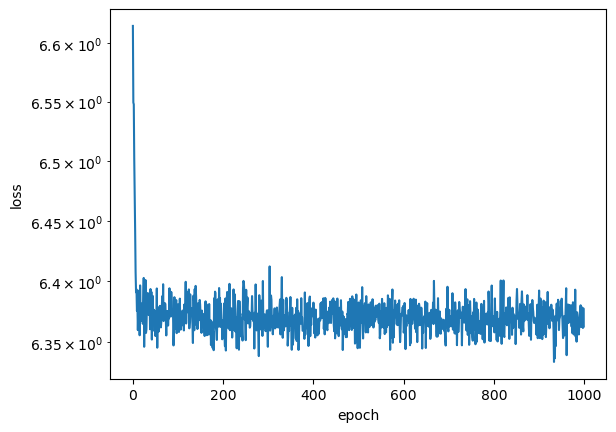

In [13]:
# import the learned model and loss train
my_net = PsiNet(nb_layers=nb_layers, mode='elastic').to(device_predict)
my_net.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))
new_iterator = PsiIterator(device_predict, nb_layers=nb_layers, psi_net=my_net, n=n_elem, batch_size=bs, mode='elastic')

my_loss = torch.load(os.path.join(model_dir,model_name+'.pt'))
plt.plot(my_loss)
plt.ylabel('loss')
plt.yscale('log')
plt.xlabel('epoch')
plt.savefig('results/smoother_loss.jpg', dpi=500, bbox_inches='tight')

0 2.976002858504809
1 0.8382965824654051
2 0.4661112458630778
3 0.41144733934953553
4 0.37853557120812487
5 0.35110911658292865
6 0.3280776582455341
7 0.30814510239542553
8 0.2908656570156981
9 0.27568641429197804
10 0.262237007104064
11 0.2501969321716977
12 0.2393228474228361
13 0.2294198130436287
14 0.2203349582787928
15 0.2119466571206753
16 0.20415790939794878
17 0.196890713161244
18 0.19008186338222585
19 0.1836797129128269
20 0.1776416703470069
21 0.1719322832657609
22 0.16652174984445736
23 0.16138477015113692
24 0.15649965124914567
25 0.15184761073337058
26 0.1474122312837262
27 0.14317903257179249
28 0.13913513350102977
29 0.13526898465409018
30 0.13157015520812784
31 0.128029162336636
32 0.12463733380261967
33 0.12138669659182488
34 0.11826988603997224
35 0.11528007115869232
36 0.11241089281889818
37 0.10965641218885241
38 0.10701106739238288
39 0.10446963679253299
40 0.10202720764617057
41 0.09967914913918043
42 0.09742108901715688
43 0.09524889318653425
44 0.09315864778614

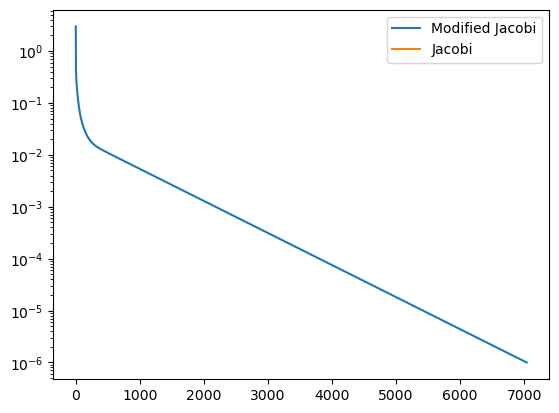

In [14]:
EPS = 1e-6
with torch.no_grad():
    n_new = 0
    u_test = torch.zeros(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
    u_test = new_iterator.grid.jac.reset_boundary(u_test, d_test, d_idx_test)
    residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item() # fix top, apply traction force at bottom boundary
    res_arr_new = [res]
    print(n_new, res)
    while (abs(res) > EPS):
        u_test = new_iterator.PsiRelax(u_test, m_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*new_iterator.grid.net(None, None, h, u_test, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_new.append(res)
        n_new += 1
        print(n_new, res)

print("Solution converges after", n_new, "iterations ")
plt.plot(res_arr_new, label='Modified Jacobi')
plt.plot(res_arr, label='Jacobi')
plt.yscale('log')
plt.legend()
plt.show()


In [15]:
def heatmap2d(arr, fname, cbar = True):
    plt.imshow(arr,cmap='viridis',vmin=-1,vmax=1)
    if(cbar is True):
        plt.colorbar()
    plt.gcf()
    plt.axis('off')
    plt.savefig(fname, dpi=500, bbox_inches='tight')
    plt.show()

In [16]:
def conv_op(k1, k2, max_size=7):
    '''Perform convolution operation in infinite domain'''
    size1 = k1.shape[0]
    size2 = k2.shape[0]
    
    pad1 = int((max_size-size1)/2)
    pad2 = int((max_size-size2)/2)

    k1_pad = F.pad(k1,(pad1,pad1,pad1,pad1))
    k2_pad = F.pad(k2,(pad2,pad2,pad2,pad2))
    delta = int(max_size/2)

    out_k = torch.zeros((max_size,max_size))
    for u in range(-delta, -delta+max_size):
        for v in range(-delta, -delta+max_size):
            for i in range(-delta, -delta+max_size):
                for j in range(-delta, -delta+max_size):
                    ii = u-i 
                    jj = v-j 
                    multiplier = 0.0
                    if(ii >= -delta and ii <= delta and jj >= -delta and jj <= delta):
                        multiplier = k1_pad[ii+delta,jj+delta]
                    out_k[u+delta,v+delta] += multiplier * k2_pad[i+delta,j+delta]

    return out_k

In [18]:
# plot the kernels (u1)
# mlist = list(my_net.cpu().parameters())
# kernel1 = conv_op(mlist[0][0].view(3,3).detach(), mlist[1][0].view(3,3).detach(), max_size=5)
# kernel2 = conv_op(kernel1, mlist[2][0].view(3,3).detach(), max_size=7)
# kernel2 = kernel2.reshape(1,1,7,7)
# heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [19]:
# plot the kernels (u2)
# kernel1 = conv_op(mlist[0][1].view(3,3).detach(), mlist[1][1].view(3,3).detach(), max_size=5)
# kernel2 = conv_op(kernel1, mlist[2][1].view(3,3).detach(), max_size=7)
# kernel2 = kernel2.reshape(1,1,7,7)
# heatmap2d(kernel2.view(7,7).detach().numpy(),fname='results/kernel_comb.jpg')

In [20]:
# test multigrid performance

class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, chs):
        super(RestrictionNet, self).__init__()
        self.chs = chs
        self.net = nn.Conv2d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restriction
        self.edge_net = nn.Conv1d(in_channels=chs, out_channels=chs, kernel_size=3, stride=2, bias=False, groups=chs) # restrict the edge boundaries
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            self.edge_net.state_dict()['weight'][i][0] = torch.asarray([1., 2., 1.]) / 2.0
    
    def forward(self, x):
        internal = self.net(x[:, :, 1:-1, 1:-1].clone())
        x_C = F.pad(internal,(1,1,1,1),"constant",0) # coarse grid field
        x_C[:, :,  0, 1:-1] = self.edge_net(x[:, :, 0, 1:-1].clone())
        x_C[:, :, -1, 1:-1] = self.edge_net(x[:, :, -1, 1:-1].clone())
        x_C[:, :, 1:-1,  0] = self.edge_net(x[:, :, 1:-1, 0].clone())
        x_C[:, :, 1:-1, -1] = self.edge_net(x[:, :, 1:-1, -1].clone())
        x_C[:,:,0,0] = x[:,:,0,0]
        x_C[:,:,0,-1] = x[:,:,0,-1]
        x_C[:,:,-1,0] = x[:,:,-1,0]
        x_C[:,:,-1,-1] = x[:,:,-1,-1]
        return x_C


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, chs):
        super(ProlongationNet, self).__init__()
        self.chs = chs
        self.net = nn.ConvTranspose2d(in_channels=chs,out_channels=chs, kernel_size=3, stride=2, padding=1, bias=False, groups=chs) # interpolation
        for i in range(self.chs):
            self.net.state_dict()['weight'][i][0] = torch.asarray([[1., 2., 1.],
                                                                   [2., 4., 2.],
                                                                   [1., 2., 1.]]) / 4.0
            
    def forward(self, x): 
        return self.net(x)

In [21]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, pacnet, device, nb_layers, mode='thermal', iterator = 'jac'):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.device = device
        self.size = 2.
        self.nb_layers = nb_layers
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.pacnet = pacnet
        self.iterator = iterator
        
        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2

        self.iterators = self.IteratorDict() # dictionary of iterators

        # Inter-grid communication network models
        self.conv = RestrictionNet(self.kf).double().to(device)
        self.deconv = ProlongationNet(self.ku).double().to(device)
        
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)

        self.mse_loss = nn.MSELoss()
    
    def IteratorDict(self):
        iterators = {}
        for i in range(self.L):
            prob_size = int(self.n/(2.**i))
            iterators[i] = PsiIterator(self.device, size=self.size, psi_net=self.pacnet, n=prob_size, nb_layers=self.nb_layers, mode=self.mode)
        return iterators
            
    def ProblemDictArray(self, u0, f, t, t_idx, d, d_idx, m):
        '''
        Array of dictionary that stores the problem hierarchy
        There are two approaches that can be used to create grid hierarchy:
        1) mat = F.conv2d(mat.reshape((1,1,n,n)), torch.ones((1,1,1,1)), stride=2)
        2) mat = F.max_pool2d(mat.reshape((1,1,n,n)), kernel_size=2, stride=2)
        '''
        kernel_u = torch.ones((self.ku,1,1,1)).double().to(self.device)
        kernel_f = torch.ones((self.kf,1,1,1)).double().to(self.device)
        prob = {}
        prob['h'] = self.size/self.n
        prob['u0'] = self.iterators[0].grid.jac.reset_boundary(u0, d, d_idx)
        prob['f'], prob['t'], prob['t_idx'] = f.clone(), t.clone(), t_idx.clone()
        prob['d'], prob['d_idx'], prob['m'] = d.clone(), d_idx.clone(), m.clone()
        self.p_arr = [prob]
        for i in range(self.L-1):
            prob = {}
            prob['h'] = self.size/self.n*(2.**(i+1))
            prob['u0'] = F.conv2d(self.p_arr[i]['u0'], kernel_u, stride=2, groups=self.ku)
            prob['f'] = F.conv2d(self.p_arr[i]['f'], kernel_f, stride=2, groups=self.kf)
            prob['t'] = F.conv2d(self.p_arr[i]['t'], kernel_f, stride=2, groups=self.kf)
            prob['t_idx'] = F.conv2d(self.p_arr[i]['t_idx'], kernel_f, stride=2, groups=self.kf)
            prob['d'] = 0.*F.conv2d(self.p_arr[i]['d'], kernel_u, stride=2, groups=self.ku) # Dirichlet boundary is homogeneous at coarse grids
            prob['d_idx'] = F.conv2d(self.p_arr[i]['d_idx'], kernel_u, stride=2, groups=self.ku)
            prob['m'] = F.max_pool2d(self.p_arr[i]['m'], kernel_size=2, stride=2)
            self.p_arr.append(prob)

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        '''
        rFC = self.conv(rF.clone())
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def forward(self, k):
        U = self.p_arr[0]['u0'].clone()
        for i in range(k-1):
            U = self.Step(U).detach()
        self.last_v = U.clone()
        return self.Step(U)

    def Relax(self, iter, u, m, d, d_idx, term_KU=None, term_F=None, h=None, f=None, t=None, t_idx=None, n_iter=1):
        if(self.iterator == 'jac'):
            return iter.grid.jac.jacobi_convolution(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx)
        else:
            return iter.PsiRelax(u, m, d, d_idx, term_KU, term_F, h, f, t, t_idx, n_iter)

    def Step(self, v):
        '''Input v is the initial solution on the finest grid'''
        n_relax = 1 # number of relaxations        
        self.iterators[0].grid.v = self.Relax(self.iterators[0], v, self.p_arr[0]['m'], 
                                              self.p_arr[0]['d'], self.p_arr[0]['d_idx'],
                                              None, None,
                                              self.p_arr[0]['h'], self.p_arr[0]['f'], 
                                              self.p_arr[0]['t'], self.p_arr[0]['t_idx'], 
                                              n_relax)
        self.iterators[0].grid.f = self.iterators[0].grid.net.term_F

        for j in range(0, self.L-1):
            # calculate fine grid residual
            rF = self.iterators[j].grid.net(u=self.iterators[j].grid.v, material_input=self.p_arr[j]['m'],
                                            term_F=self.iterators[j].grid.f)
            self.iterators[j+1].grid.f = self.Restrict(rF)
            self.iterators[j+1].grid.v = torch.zeros_like(self.iterators[j+1].grid.f) 
            self.iterators[j+1].grid.v = self.Relax(self.iterators[j+1], self.iterators[j+1].grid.v, 
                                              self.p_arr[j+1]['m'], 
                                              self.p_arr[j+1]['d'], self.p_arr[j+1]['d_idx'],
                                              term_F=self.iterators[j+1].grid.f, 
                                              n_iter=n_relax)

        self.iterators[self.L-1].grid.v = self.Relax(self.iterators[self.L-1], self.iterators[self.L-1].grid.v, 
                                              self.p_arr[self.L-1]['m'], 
                                              self.p_arr[self.L-1]['d'], self.p_arr[self.L-1]['d_idx'],
                                              term_F=self.iterators[self.L-1].grid.f, 
                                              n_iter=n_relax)

        for j in range(self.L-2,-1,-1):
            eF_delta = self.Interpolate(self.iterators[j+1].grid.v)
            self.iterators[j].grid.v = self.iterators[j].grid.v + eF_delta
            self.iterators[j].grid.v = self.Relax(self.iterators[j], self.iterators[j].grid.v, 
                                              self.p_arr[j]['m'], 
                                              self.p_arr[j]['d'], self.p_arr[j]['d_idx'],
                                              term_F=self.iterators[j].grid.f, 
                                              n_iter=n_relax)

            # zero out the previous level solution
            self.iterators[j+1].grid.v *= 0. 

        return self.iterators[0].grid.v 

In [22]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=2
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [23]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 6.707527176100344
1 1.4384118477427956
2 0.7473353837876502
3 0.415067612396803
4 0.23966833222117934
5 0.14727536503600705
6 0.10093226136234501
7 0.07945886945601624
8 0.06995111080411973
9 0.0654375253263683
10 0.0628369291044135
11 0.06096156778282976
12 0.0593769013353911
13 0.0579240866936707
14 0.056543588532691855
15 0.055212198496837096
16 0.0539203892510878
17 0.05266395260033381
18 0.051440797688725906
19 0.05024967678997866
20 0.0490896621157834
21 0.047959928894648514
22 0.04685966870440947
23 0.04578805978565992
24 0.04474426228202402
25 0.04372742379286252
26 0.04273668841150574
27 0.041771206073713776
28 0.04083014081930687
29 0.03991267745389722
30 0.03901802653515327
31 0.03814542781516822
32 0.03729415235662432
33 0.036463503563082325
34 0.03565281735417906
35 0.034861461691816344
36 0.034088835633247105
37 0.033334368056181
38 0.03259751617254143
39 0.03187776392225522
40 0.031174620316981635
41 0.030487617785874634
42 0.02981631056097015
43 0.029160273128232408
4

In [24]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


0 6.707527176100344
1 0.4358584526038392
2 0.07615347790097372
3 0.05667190262227768
4 0.04460731511097034
5 0.03520090653656309
6 0.027844803178925934
7 0.022059314084027892
8 0.017489583857396792
9 0.013871321601346086
10 0.011003090783973404
11 0.0087283186763314
12 0.006923901956947357
13 0.005492514264341478
14 0.0043570304097833405
15 0.0034562826630856326
16 0.0027417475816753035
17 0.002174930845367971
18 0.0017252948486593466
19 0.0013686145406249575
20 0.0010856727903861003
21 0.0008612252394744765
22 0.0006831790519192651
23 0.0005419414042239184
24 0.00042990265062188907
25 0.0003410263314032609
26 0.00027052393958431736
27 0.00021459692445845727
28 0.00017023203216357574
29 0.00013503895662361797
30 0.00010712155388020532
31 8.497568103662059e-05
32 6.74081555592702e-05
33 5.3472468598595235e-05
34 4.241778868131784e-05
35 3.364850817376826e-05
36 2.6692152924957597e-05
37 2.1173926171731578e-05
38 1.6796515096942425e-05
39 1.3324072117406061e-05
40 1.0569507829000842e-05


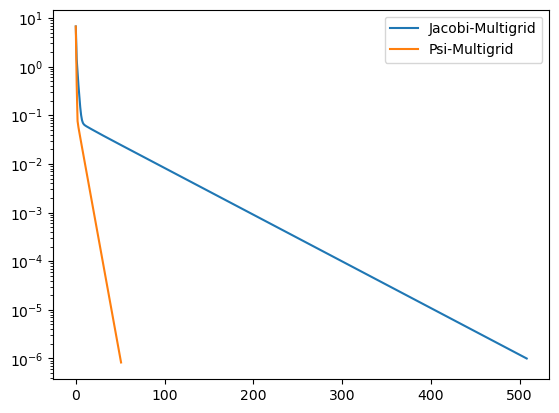

In [25]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr_mgpsi, label='Psi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()